In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pysdaza as sd

# Reentry Chile Response Rate

*Sebastian Daza*

In this report we describe response rates by wave. We follow these general criteria:

- The estimation by wave only uses cases far beyond the wave-specific observation window. For instance, for the wave 2-months, we only consider those women who have been in the study for 4 months.
- This estimation is based on the administrative records of the study.

Some important definitions:

- Names of waves: baseline, week, two_months, six_months, twelve_months
- Variables names: `d` means date, `c` means clean, and `cd` clean date
- Deadline corresponds to th time threshold to compute a given response rate

We display key date variables to compute the rates and highlight inconsistencies or problems. 

In [2]:
# getting paths
import os
myfile =  os.getcwd() + '/data/Registro general de terreno_todas las olas.xlsx'

## Release
There are two date of release variables
in the register data. *Definitive* has a bunch of missing records. **We should define a validated and unique date for release**. 

In [5]:
import pandas as pd
import numpy as np
import re 

In [6]:
# read excel file
df = pd.read_excel(myfile, skiprows=[0,1])

In [7]:
df.columns = df.columns.str.strip()

In [8]:
variables = set(df.columns.tolist())

In [9]:
# extract columns
cols = ['enc','folio','fegresoefectiva', 'lb_fechaentrevista', 'lb_participa', 
       'primsem_fechaentrevista', 'primsem_participa', 'dosmeses_fechaentrevista', 
        'dosmeses_participa', 'seismeses_fechaentrevista', 'seismeses_participa', 
       'docemeses_fechaentrevista', 'docemeses_participa']

len(cols)

13

In [10]:
df = df.loc[:,cols]

In [11]:
cols = ['enc','folio','fegresoefectiva', 'lb_fechaentrevista', 'lb_participa', 
       'primsem_fechaentrevista', 'primsem_participa', 'dosmeses_fechaentrevista', 
        'dosmeses_participa', 'seismeses_fechaentrevista', 'seismeses_participa', 
       'docemeses_fechaentrevista', 'docemeses_participa']

In [12]:
# rename columns
names = ["int","id", "release_f","dbaseline","r_baseline",
         "dweek","r_week","d2months","r_2months",
         "d6months","r_6months","d12months","r_12months"]

df.rename(columns=dict(zip(df.columns, names)), inplace=True)

In [13]:
null = df.int.notnull()
df = df.loc[null, names]

In [14]:
df.shape

(226, 13)

In [15]:
# remove cases?
remove_cases = [10011] # only case that's not valid

# df.id in remove_cases
df = df.loc[~df.id.isin(remove_cases),:]
df.shape

(225, 13)

In [16]:
# # save data
# import dill

# dill.dump(df, open('data/registro.pkl', 'wb'))

# # load the data
# df = dill.load(open('data/registro.pkl', 'rb'))

In [17]:
# no valid records for release_f?
s = df.release_f.isnull()
s.describe()

count       225
unique        1
top       False
freq        225
Name: release_f, dtype: object

In [18]:
df['release_year'] = pd.DatetimeIndex(df['release_f']).year
df['release_month'] = pd.DatetimeIndex(df['release_f']).month

In [19]:
# release plot
t = df.reset_index().set_index('release_f')
t = t.resample('M')

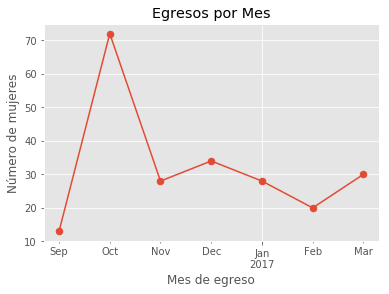

In [20]:
ax = t.id.count().plot(title='Egresos por Mes', style='.-', ms=13);
ax.set_ylabel("Número de mujeres");
ax.set_xlabel("Mes de egreso");

## Baseline

Let's explore the baseline information. Below a plot with the distribution of the difference between the date of the baseline and release. All values should be **negative**. 

To check cases below where we have issues: missing data or positive value (i.e., the baseline was applied after release). 

In [21]:
# correct some dates
df.loc[df.dbaseline.isnull(),['int','id', 'dbaseline', 'r_baseline']]

,int,id,dbaseline,r_baseline


In [22]:
# function to clean dates
def clean_dates(text):
   if (isinstance(text, str)):
      text = str(text)
      pp = re.compile("-|\.")
      r = re.sub(pp, "/", text)
      pp = re.compile("([0-9]+/[0-9]+/[0-9]+)|([0-9]+-[0-9]+-[0-9]+)")
      r = re.search(pp, r)
      if (r is not None):
         r = r.group()
      else:
         r = ''
   else:
      r = text
   return pd.to_datetime(r, dayfirst=True, errors = 'coerce')

In [23]:
df['cdbaseline'] = [clean_dates(i) for i in df['dbaseline']]

In [24]:
df = df.assign(release_baseline = (df.cdbaseline - df.release_f).dt.days) # it has to be negative
s = ((df.release_baseline > 0) | (df.cdbaseline.isnull()))
df.loc[s, ['int', 'id', 'r_baseline', 'release_f',  'cdbaseline', 'dbaseline', 'release_baseline']].sort_values('id')

,int,id,r_baseline,release_f,cdbaseline,dbaseline,release_baseline
219,Javiera,10083,Sí,2016-10-19,2016-10-22,2016-10-22 00:00:00,3.0
163,Pati,20112,SI,2016-10-19,NaT,19-10-016,NaN
157,Marcela,50037,SI,2016-10-19,2017-09-30,2017-09-30 00:00:00,346.0


Descriptives of the difference between release date and baseline: 

In [25]:
df.release_baseline.describe()

count    224.000000
mean     -11.660714
std       36.748217
min     -367.000000
25%      -14.000000
50%       -7.000000
75%       -4.000000
max      346.000000
Name: release_baseline, dtype: float64

## First week


Below a plot with the distribution of the difference between the date of the first week interview and release. All values should be **positive**. 


In [26]:
df['r_week'] = df['r_week'].str.contains("s|S").astype(float)
df['r_week'] = df.r_week.fillna(0)
df.r_week.value_counts()

1.0    181
0.0     44
Name: r_week, dtype: int64

In [27]:
df['cdweek'] = [clean_dates(i) for i in df['dweek']]

In [28]:
m = df.cdweek.isnull() & df.dweek.notnull()

In [29]:
df = df.assign(release_week = (df.cdweek - df.release_f).dt.days)
(df.release_week > 7).value_counts()

True     145
False     80
Name: release_week, dtype: int64

Plot of the difference between date of release and first week interview.

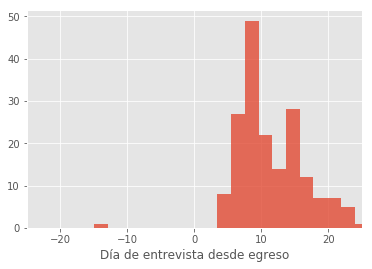

In [30]:
ax = df.release_week.hist(bins = 20, alpha = 0.8);
ax.set_xlim(-25,25)
ax.set_xlabel('Día de entrevista desde egreso');

In [31]:
df['week_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(weeks = 5) # five weeks!

Cases with issues: 

In [32]:
import datetime
today = datetime.datetime.now()

In [33]:
s = ((df.r_week == 1) & (today > df.week_deadline)) & ( (df.release_week <= 0) | (df.cdweek.isnull()) )

In [34]:
df.loc[np.abs(df.release_week) > 30,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week


Interviews before the first 7 days. The only weird case is 10053!

In [35]:
df.loc[df.release_week < 7,['int', 'id', 'r_week', 'release_f', 'cdweek', 'release_week']]

,int,id,r_week,release_f,cdweek,release_week
32,Susana,40284,1.0,2017-03-15,2017-03-21,6.0
42,Susana,40268,1.0,2017-03-01,2017-03-07,6.0
62,Pati,20239,1.0,2017-02-01,2017-02-06,5.0
66,Susana,40194,1.0,2016-12-24,2016-12-30,6.0
72,Susana,40225,1.0,2017-01-16,2017-01-21,5.0
76,Susana,40215,1.0,2017-01-11,2017-01-16,5.0
84,Susana,40199,1.0,2016-12-30,2017-01-04,5.0
100,Pati,20181,1.0,2016-12-09,2016-12-15,6.0
105,Susana,40107,1.0,2016-12-01,2016-12-06,5.0
118,Susana,40169,1.0,2016-12-02,2016-12-07,5.0


Response rate:

In [36]:
tab  = df.loc[ (today > df.week_deadline) | (df.r_week == 1), 'r_week'].value_counts()
rr_week = [i / sum(list(tab)) for i in tab][0]
print(rr_week)

0.8044444444444444


Descriptives of the difference between date of release and interview first week. 

In [37]:
df.loc[df.r_week == 1, 'release_week'].describe()

count    181.000000
mean      11.209945
std        4.930642
min      -15.000000
25%        8.000000
50%       10.000000
75%       14.000000
max       26.000000
Name: release_week, dtype: float64


# Two Months
 

In [38]:
df['r_2months'] = df['r_2months'].str.contains("s|S").astype(float)
df['r_2months'] = df.r_2months.fillna(0)

In [39]:
df['cd2months'] = [clean_dates(i) for i in df['d2months']]

Some cases with issues:

In [40]:
# replace errors in data entry
# errors = ['27/2']
# new_values = ['02/27/2017']

# for i in range(0,len(errors)):
#    df.loc[df['d2months'] == errors[i], 'cd2months'] = pd.to_datetime(new_values[i])

In [41]:
s = (df.r_2months == 1)
#df.loc[s, 'cd2months'].isnull().value_counts()

In [42]:
df = df.assign(release_2months = (df.cd2months - df.release_f).dt.days)
#df.release_2months.describe()

Plot of the difference between release and date of two-months interview.

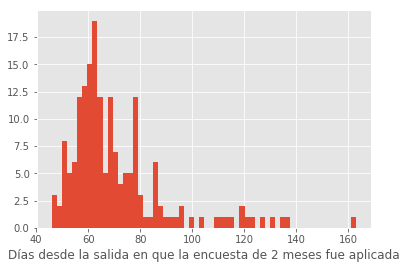

In [43]:
ax = df.release_2months.hist(bins = 60);
ax.set_xlabel('Días desde la salida en que la encuesta de 2 meses fue aplicada');

Some issues:

In [44]:
df['two_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 5)
s = ((df.r_2months == 1) & (today > df.two_months_deadline)) & ( (df.release_2months <= 0) | (df.cd2months.isnull()))
df.loc[s,['int', 'id', 'r_2months', 'release_f', 'cd2months', 'two_months_deadline', 'release_2months']].sort_values('id')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months


In [45]:
tab  = df.loc[ (today > df.two_months_deadline) | (df.r_2months == 1), 'r_2months'].value_counts()
# print(tab)
rr_2months = [i / sum(list(tab)) for i in tab][0]
# print(rr_2months)

In [46]:
df.loc[np.abs(df.release_2months) > 100,['int', 'id', 'r_2months', 'release_f', 
                                         'cd2months', 'two_months_deadline', 
                                         'release_2months']].sort_values('release_2months')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months
75,Marisol,10291,1.0,2017-03-22,2017-07-04,2017-08-22,104.0
23,Marcela,50249,1.0,2017-02-09,2017-05-30,2017-07-09,110.0
27,Javiera,10233,1.0,2017-01-25,2017-05-17,2017-06-25,112.0
158,Javiera,10087,1.0,2016-10-19,2017-02-09,2017-03-19,113.0
143,Susana,40152,1.0,2016-11-16,2017-03-11,2017-04-16,115.0
54,Marcela,50180,1.0,2016-12-07,2017-04-05,2017-05-07,119.0
86,Pati,20224,1.0,2017-01-16,2017-05-16,2017-06-16,120.0
30,Marisol,50271,1.0,2017-03-06,2017-07-06,2017-08-06,122.0
22,Marcela,50281,1.0,2017-03-12,2017-07-13,2017-08-12,123.0
199,Marcela,50205,1.0,2016-12-28,2017-05-03,2017-05-28,126.0


In [47]:
df.loc[np.abs(df.release_2months) < 10 ,['int', 'id', 
                                         'r_2months', 'release_f', 'cd2months', 
                                         'two_months_deadline', 
                                         'release_2months']].sort_values('release_2months')

,int,id,r_2months,release_f,cd2months,two_months_deadline,release_2months


Descriptives:

In [48]:
df.loc[df.r_2months == 1, 'release_2months'].describe()

count    177.000000
mean      70.632768
std       19.317198
min       46.000000
25%       59.000000
50%       64.000000
75%       78.000000
max      163.000000
Name: release_2months, dtype: float64

## Six Months

In [49]:

df.r_6months.value_counts()
df['r_6months'] = df['r_6months'].str.contains("s|S").astype(float)
df['r_6months'] = df.r_6months.fillna(0)


In [50]:
df['cd6months'] = [clean_dates(i) for i in df['d6months']]

m = df.cd6months.isnull() & df.d6months.notnull()
m.value_counts()

False    225
dtype: int64

In [51]:
s = (df.r_6months == 1)

There is some issues here:

In [52]:
df.loc[df.id == 50209, 'cd6months']

95   2017-07-30
Name: cd6months, dtype: datetime64[ns]

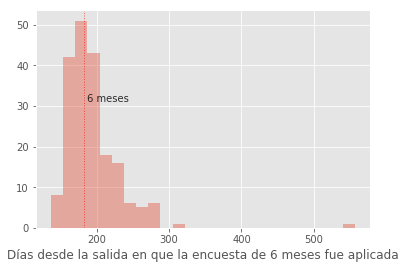

In [53]:
df = df.assign(release_6months = (df.cd6months - df.release_f).dt.days)

sns.distplot(df.loc[df.r_6months==1, 'release_6months'], bins=25, kde=False);
plt.axvline(x=(30.5*6), color='r', ls='dotted', alpha=0.6, lw=1)
plt.text(187, 31, '6 meses', alpha=0.8)
plt.xlabel('Días desde la salida en que la encuesta de 6 meses fue aplicada');
plt.savefig('plots/dias_6meses.pdf', dpi = 600)

In [54]:
df['six_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 7)
                                                                
s = ((df.r_6months == 1) & (today > df.six_months_deadline)) & (
    (df.release_6months <= 0) | (df.cd6months.isnull()))

df.loc[s,['int', 'id', 'r_6months', 'release_f', 'd6months', 
          'cd6months', 'six_months_deadline', 'release_6months']].sort_values('id')

,int,id,r_6months,release_f,d6months,cd6months,six_months_deadline,release_6months


### Cases higher than 240 days since release

r6_months (if respondent took part of wave 6 months) is not always consistent!

In [55]:
df.loc[np.abs(df.release_6months) > 240, ['int', 'id', 'r_6months', 'release_f', 'cd6months', 
                                          'six_months_deadline', 
                                          'release_6months']].sort_values('release_6months')

,int,id,r_6months,release_f,cd6months,six_months_deadline,release_6months
139,Marisol,50104,1.0,2016-10-24,2017-06-27,2017-05-24,246.0
187,Marcela,50060,1.0,2016-10-19,2017-06-26,2017-05-19,250.0
127,Javiera,30139,1.0,2016-11-04,2017-07-12,2017-06-04,250.0
131,Marisol,50070,1.0,2016-10-22,2017-06-29,2017-05-22,250.0
162,Susana,10149,1.0,2016-11-14,2017-07-27,2017-06-14,255.0
176,Javiera,30021,1.0,2016-10-02,2017-06-21,2017-05-02,262.0
81,Marcela,50154,1.0,2016-11-18,2017-08-08,2017-06-18,263.0
121,Marcela,50150,1.0,2016-11-14,2017-08-08,2017-06-14,267.0
150,Javiera,30116,1.0,2016-10-19,2017-07-14,2017-05-19,268.0
120,Pati,20081,1.0,2016-10-19,2017-07-18,2017-05-19,272.0


### Cases lower than 150 days since release

Same issue with r_6months

In [56]:
df.loc[np.abs(df.release_6months) < 150, ['int', 'id', 'r_6months', 'release_f', 'cd6months', 
                                          'six_months_deadline', 
                                          'release_6months']].sort_values('release_6months')

,int,id,r_6months,release_f,cd6months,six_months_deadline,release_6months
85,Pati,10182,1.0,2016-12-30,2017-05-16,2017-07-30,137.0
69,Susana,10098,1.0,2017-01-26,2017-06-20,2017-08-26,145.0
143,Susana,40152,1.0,2016-11-16,2017-04-11,2017-06-16,146.0
25,Susana,40235,1.0,2017-03-17,2017-08-11,2017-10-17,147.0


In [57]:
tab  = df.loc[(today > df.six_months_deadline)  | (df.r_6months == 1), 'r_6months'].value_counts()
# print(tab)
rr_6months = [i / sum(list(tab)) for i in tab][0]
print(rr_6months)

0.8755555555555555


Some descriptives:

In [58]:
df.loc[df.r_6months == 1, 'release_6months'].describe()

count    197.000000
mean     194.923858
std       40.503707
min      137.000000
25%      170.000000
50%      186.000000
75%      208.000000
max      557.000000
Name: release_6months, dtype: float64

# Year

In [59]:
df.r_12months.value_counts()
df['r_12months'] = df['r_12months'].str.contains("s|S").astype(float)
df['r_12months'] = df.r_12months.fillna(0)

In [60]:
df.r_12months.value_counts()

1.0    200
0.0     25
Name: r_12months, dtype: int64

In [61]:
df['cd12months'] = [clean_dates(i) for i in df['d12months']]

m = df.cd12months.isnull() & df.d12months.notnull()
m.value_counts()

False    224
True       1
dtype: int64

In [62]:
s = (df.r_12months == 1)
s.value_counts()

True     200
False     25
Name: r_12months, dtype: int64

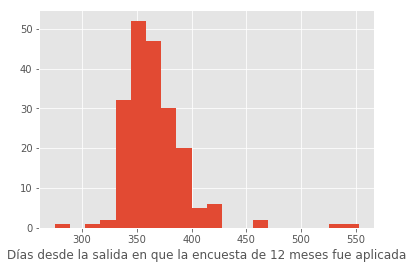

In [63]:
df = df.assign(release_12months = (df.cd12months - df.release_f).dt.days)

ax = df.release_12months.hist(bins = 20);
ax.set_xlabel('Días desde la salida en que la encuesta de 12 meses fue aplicada')
plt.savefig('plots/dias_12meses.pdf', dpi = 600);

In [64]:
df['twelve_months_deadline'] = pd.DatetimeIndex( df['release_f'] ) + pd.DateOffset(months = 12)

s = ((df.r_12months == 1) & (today > df.twelve_months_deadline)) & (
    (df.release_12months <= 0) | (df.cd12months.isnull()))

df.loc[s,['int', 'id', 'r_12months', 'release_f', 'd12months', 
          'cd12months', 'twelve_months_deadline', 'release_12months']].sort_values('id')

,int,id,r_12months,release_f,d12months,cd12months,twelve_months_deadline,release_12months


In [65]:
tab  = df.loc[(today > df.twelve_months_deadline)  | (df.r_12months == 1), 'r_12months'].value_counts()
# print(tab)
rr_12months = [i / sum(list(tab)) for i in tab][0]
print(rr_12months)

0.8888888888888888


In [66]:
df.loc[np.abs(df.release_12months) > 380, ['int', 'id', 'r_12months', 'release_f', 'cd12months', 
                                          'twelve_months_deadline', 
                                          'release_12months']].sort_values('release_12months')

,int,id,r_12months,release_f,cd12months,twelve_months_deadline,release_12months
47,Javiera,30227,1.0,2017-01-17,2018-02-02,2018-01-17,381.0
73,Javiera,30183,1.0,2016-12-10,2017-12-27,2017-12-10,382.0
66,Susana,40194,1.0,2016-12-24,2018-01-10,2017-12-24,382.0
53,Marcela,50214,1.0,2017-01-08,2018-01-25,2018-01-08,382.0
178,Susana,10003,1.0,2016-09-16,2017-10-03,2017-09-16,382.0
199,Marcela,50205,1.0,2016-12-28,2018-01-15,2017-12-28,383.0
124,Susana,40050,1.0,2016-10-19,2017-11-06,2017-10-19,383.0
13,Pati,20201,1.0,2017-03-02,2018-03-20,2018-03-02,383.0
4,Javiera,30303,1.0,2017-03-15,2018-04-03,2018-03-15,384.0
8,Pati,20279,1.0,2017-03-10,2018-03-29,2018-03-10,384.0


In [67]:
df.loc[df.r_12months == 1, 'release_12months'].describe()

count    200.000000
mean     367.050000
std       29.594029
min      275.000000
25%      349.000000
50%      362.000000
75%      380.000000
max      553.000000
Name: release_12months, dtype: float64

# Plot of interview days by wave

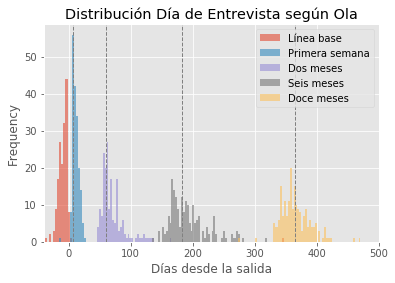

In [68]:
ax = df.loc[:, ['release_baseline', 'release_week', 'release_2months', 
                'release_6months', 'release_12months']].plot.hist(
    title='Distribución Día de Entrevista según Ola', alpha=0.6, bins = 300)
ax.set_xlim(-40,500)
ax.legend(['Línea base', 'Primera semana', 'Dos meses', 'Seis meses', 'Doce meses'])
ax.axvline(7, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*2, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(30.5*6, color = 'gray', linestyle ='--', linewidth=1)
ax.axvline(365.0, color = 'gray', linestyle ='--', linewidth=1)
ax.set_xlabel('Días desde la salida');
plt.savefig('plots/dia_entrevista_ola.pdf', dpi = 600)

## Summary rates

In [69]:
rr = pd.DataFrame( {"rate" : [rr_week, rr_2months, rr_6months, rr_12months]}, 
                       index = ['week' ,'2 months', '6 months', '12 months'])

rr

,rate
week,0.804444
2 months,0.786667
6 months,0.875556
12 months,0.888889
